In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Set working directory to the project root (1 folder up)
import os
os.chdir('..')

In [3]:
# Load the data
df_train = pd.read_csv('data/train.csv')
df_test = pd.read_csv('data/test.csv')

print(df_train.shape)
print(df_test.shape)

# Explore the data
df_train.head()

(750000, 9)
(250000, 8)


,id,Sex,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories
0,0,male,36,189.0,82.0,26.0,101.0,41.0,150.0
1,1,female,64,163.0,60.0,8.0,85.0,39.7,34.0
2,2,female,51,161.0,64.0,7.0,84.0,39.8,29.0
3,3,male,20,192.0,90.0,25.0,105.0,40.7,140.0
4,4,female,38,166.0,61.0,25.0,102.0,40.6,146.0


In [4]:
# Show overview of missing values
print(df_train.isnull().sum())

print(df_test.isnull().sum())

# No missing data


id            0
Sex           0
Age           0
Height        0
Weight        0
Duration      0
Heart_Rate    0
Body_Temp     0
Calories      0
dtype: int64
id            0
Sex           0
Age           0
Height        0
Weight        0
Duration      0
Heart_Rate    0
Body_Temp     0
dtype: int64


In [5]:
# Transform Sex to 0 and 1
df_train['Sex'] = df_train['Sex'].map({'male': 0, 'female': 1})
df_test['Sex'] = df_test['Sex'].map({'male': 0, 'female': 1})

# Transform target (Calories) with log1p
df_train['Calories'] = np.log1p(df_train['Calories'])


In [6]:
# Show column statistics 
print(df_train.describe())


                  id            Sex            Age         Height  \
count  750000.000000  750000.000000  750000.000000  750000.000000   
mean   374999.500000       0.500961      41.420404     174.697685   
std    216506.495284       0.499999      15.175049      12.824496   
min         0.000000       0.000000      20.000000     126.000000   
25%    187499.750000       0.000000      28.000000     164.000000   
50%    374999.500000       1.000000      40.000000     174.000000   
75%    562499.250000       1.000000      52.000000     185.000000   
max    749999.000000       1.000000      79.000000     222.000000   

              Weight       Duration     Heart_Rate      Body_Temp  \
count  750000.000000  750000.000000  750000.000000  750000.000000   
mean       75.145668      15.421015      95.483995      40.036253   
std        13.982704       8.354095       9.449845       0.779875   
min        36.000000       1.000000      67.000000      37.100000   
25%        63.000000       8.0000

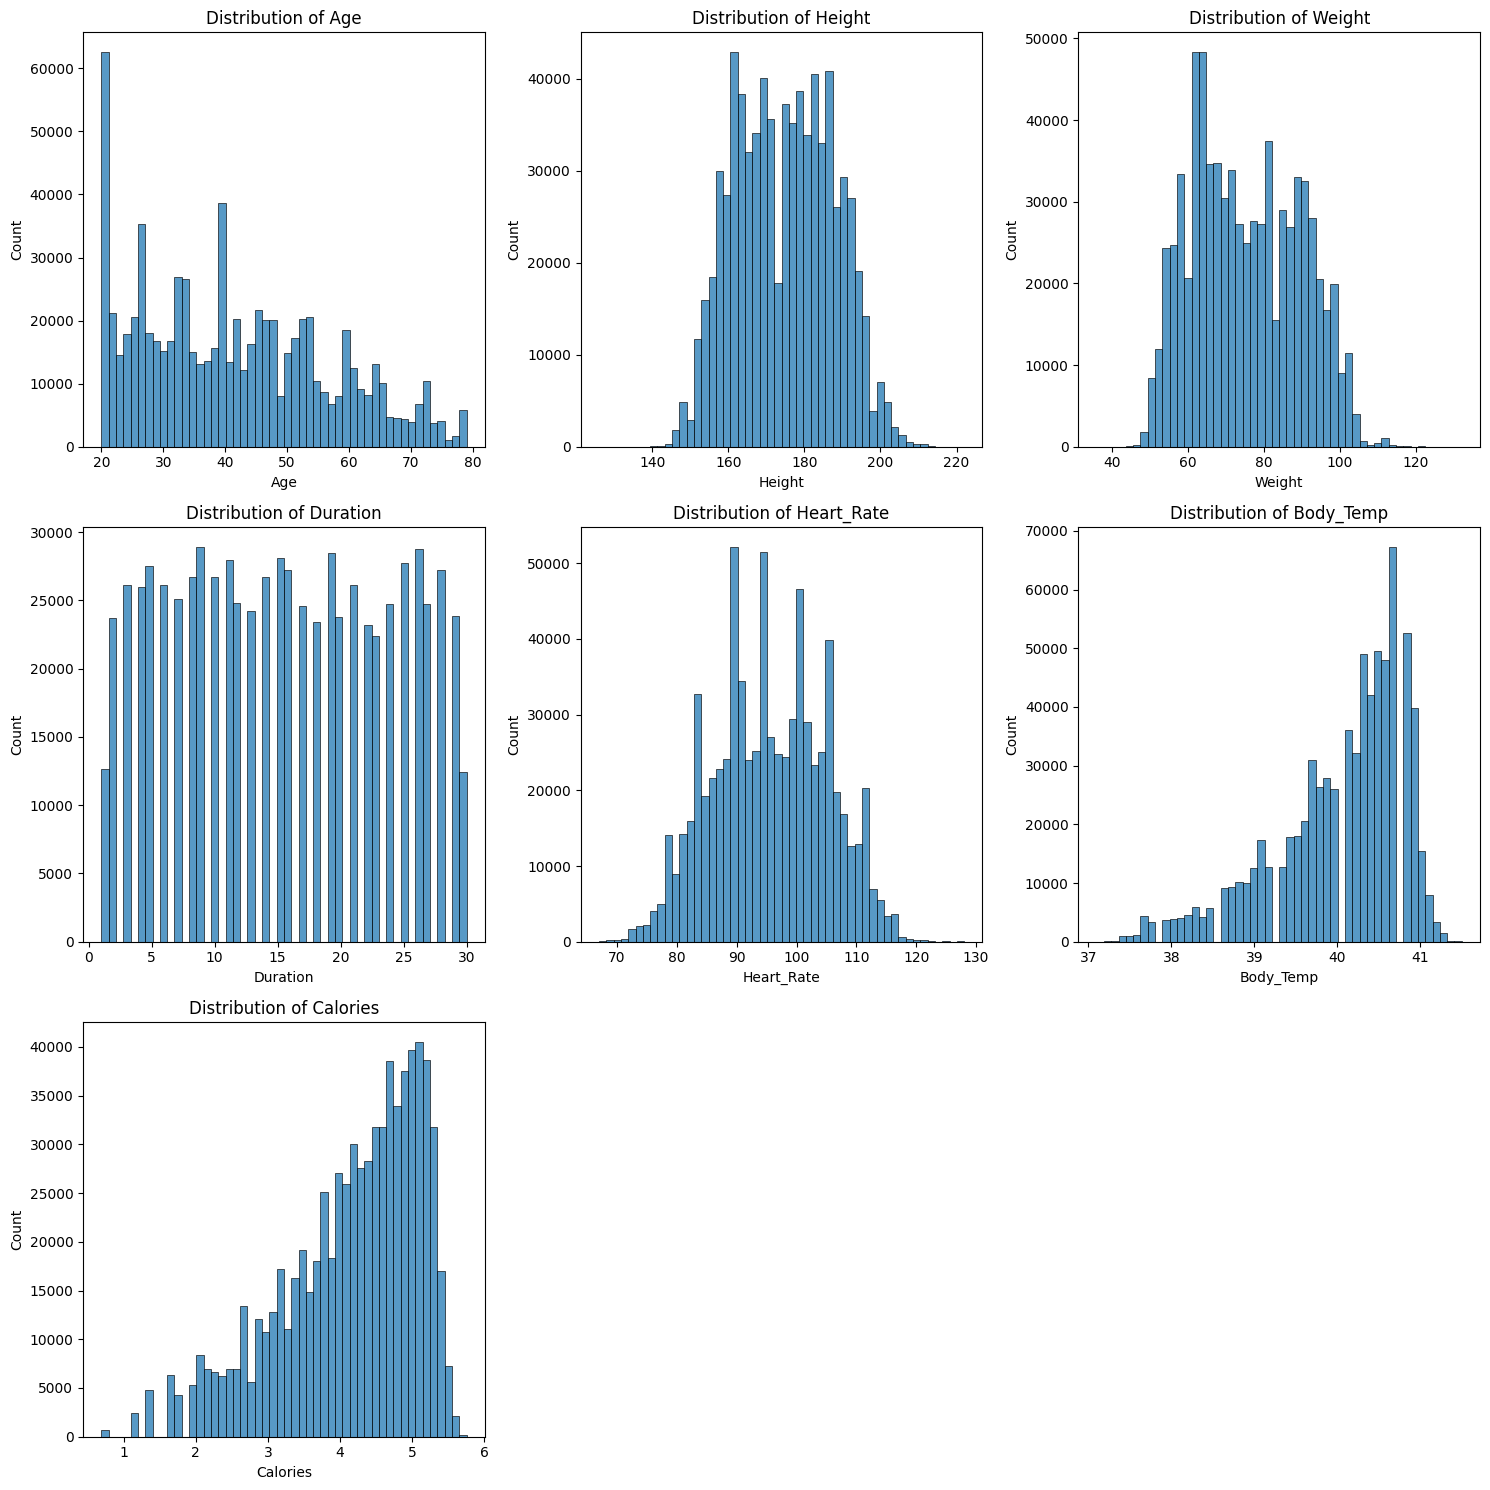

In [7]:
# Plot histograms for all numeric features
fig, axes = plt.subplots(3, 3, figsize=(15, 15))
axes = axes.ravel()

numeric_cols = ['Age', 'Height', 'Weight', 'Duration', 'Heart_Rate', 'Body_Temp', 'Calories']

for idx, col in enumerate(numeric_cols):
    sns.histplot(data=df_train, x=col, ax=axes[idx], bins=50)
    axes[idx].set_title(f'Distribution of {col}')

# Remove the empty subplot
axes[-1].remove()
axes[-2].remove()

plt.tight_layout()



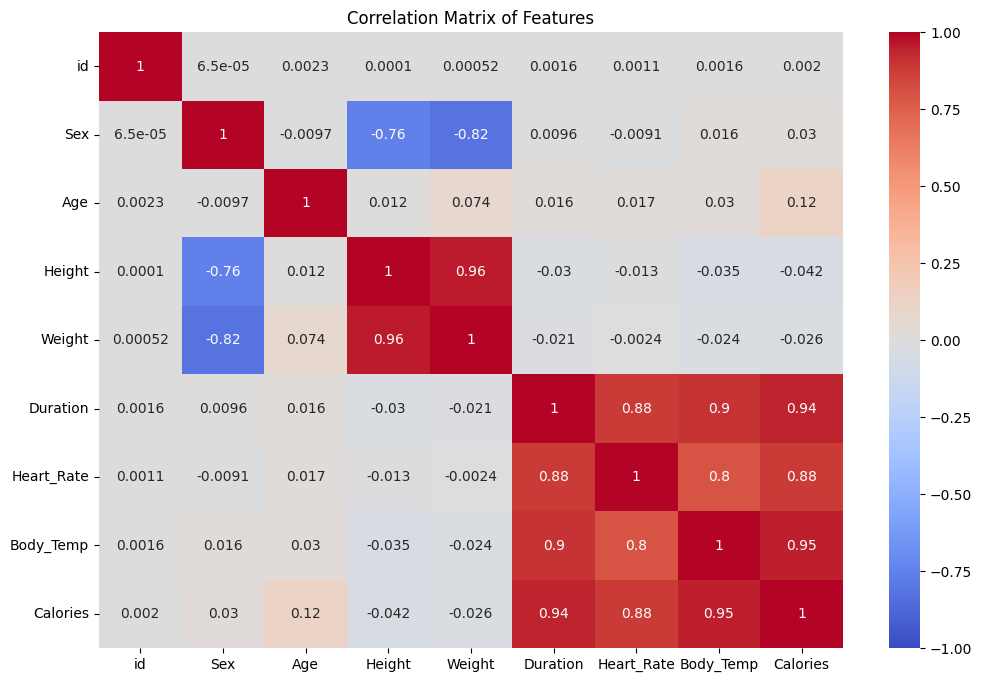

In [8]:
# Make a correlation matrix  all features
corr_matrix = df_train.corr()

# Plot the correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix of Features')
plt.show()



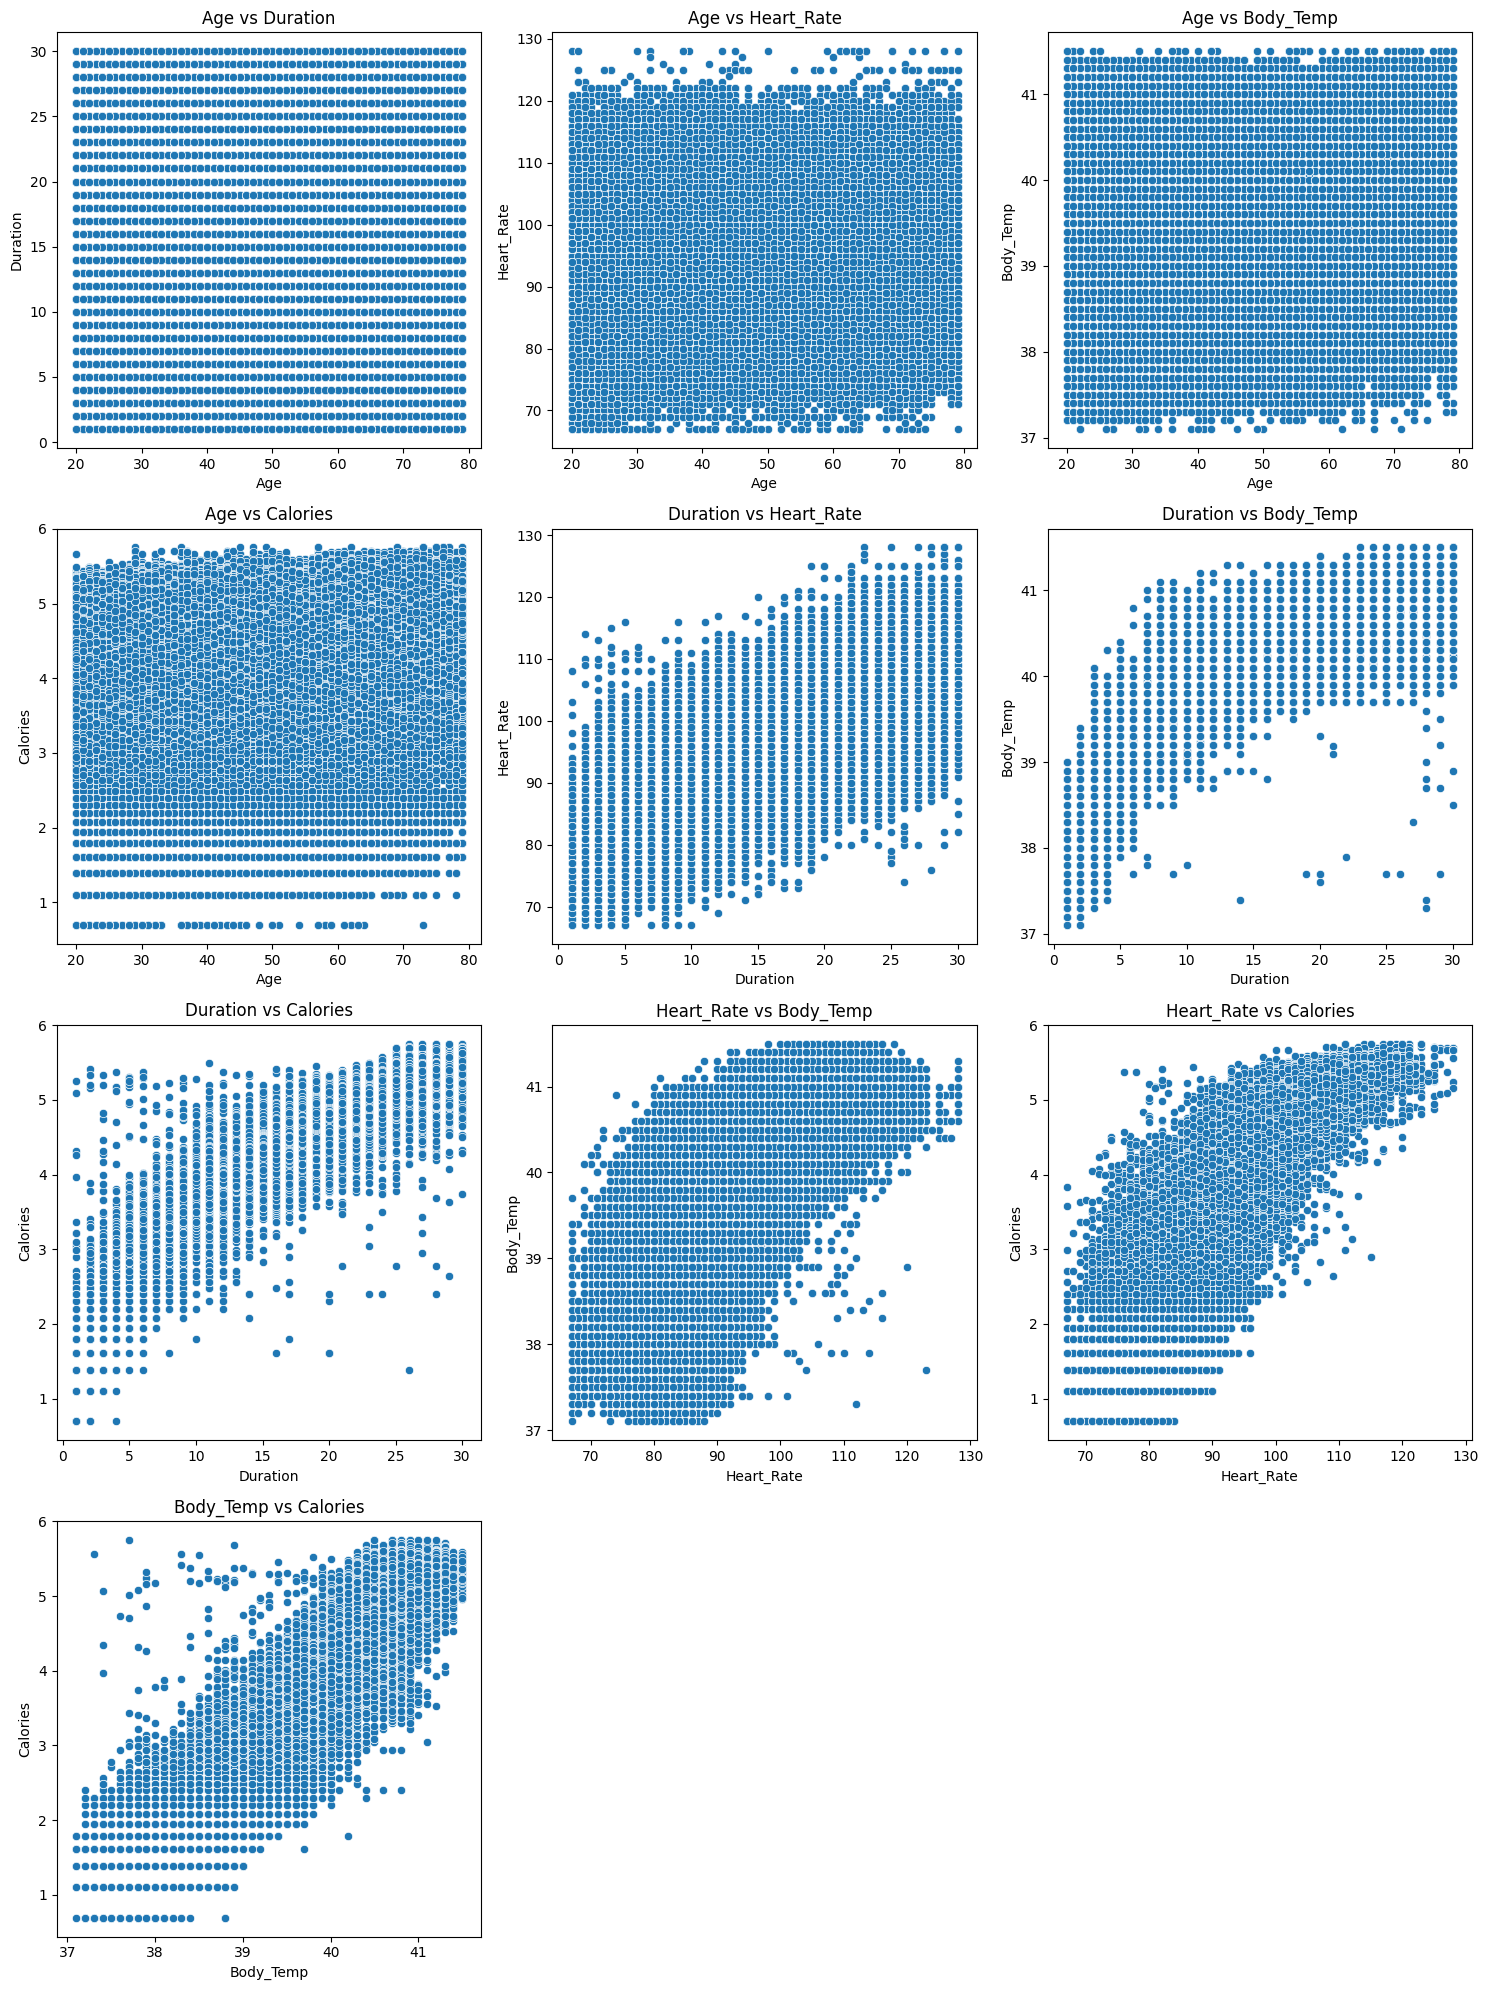

In [9]:
# Plot feature interactions using scatterplots
fig, axes = plt.subplots(4, 3, figsize=(15, 20))
axes = axes.ravel()

# Define pairs to plot
pairs = [
    ('Age', 'Duration'),
    ('Age', 'Heart_Rate'), 
    ('Age', 'Body_Temp'),
    ('Age', 'Calories'),
    ('Duration', 'Heart_Rate'),
    ('Duration', 'Body_Temp'), 
    ('Duration', 'Calories'),
    ('Heart_Rate', 'Body_Temp'),
    ('Heart_Rate', 'Calories'),
    ('Body_Temp', 'Calories')
]

# Create scatterplots
for idx, (x, y) in enumerate(pairs):
    sns.scatterplot(data=df_train, x=x, y=y, ax=axes[idx])
    axes[idx].set_title(f'{x} vs {y}')

# Remove empty subplots
axes[-1].remove()
axes[-2].remove()

plt.tight_layout()





In [10]:
# Implement basic lightgbm model on the training data
import lightgbm as lgb
from lightgbm import LGBMRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import root_mean_squared_error
import numpy as np

df_train = pd.read_csv('data/train.csv')
df_test = pd.read_csv('data/test.csv')

# Transform Sex to 0 and 1
df_train['Sex'] = df_train['Sex'].map({'male': 0, 'female': 1})
df_test['Sex'] = df_test['Sex'].map({'male': 0, 'female': 1})

# Transform target (Calories) with log1p
df_train['Calories'] = np.log1p(df_train['Calories'])

# Create column interactions between all numerical columns
numeric_cols = ['Age', 'Height', 'Weight', 'Duration', 'Heart_Rate', 'Body_Temp']

# Create interaction features
for i in range(len(numeric_cols)):
    for j in range(i+1, len(numeric_cols)):
        col1, col2 = numeric_cols[i], numeric_cols[j]
        interaction_name = f'{col1}_{col2}_interaction'
        df_train[interaction_name] = df_train[col1] * df_train[col2]
        df_test[interaction_name] = df_test[col1] * df_test[col2]

# Prepare features and target
X = df_train.drop(['Calories', 'id'], axis=1)
y = df_train['Calories']

# Split data
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Create LightGBM datasets
train_data = lgb.Dataset(X_train, label=y_train)
val_data = lgb.Dataset(X_val, label=y_val)

# Set parameters
params = {
    'objective': 'regression',
    'metric': 'rmse',
    'num_leaves': 1024,
    'max_bin': 1024,
    'learning_rate': 0.02,
    'subsample': 0.8,
    'n_estimators': 1000,
    'verbose': 1
}

model = LGBMRegressor(**params)
model.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    eval_metric='rmse',
    callbacks=[
        lgb.early_stopping(stopping_rounds=100),
        lgb.log_evaluation(period=100)
    ]
)

# Make predictions
val_preds = model.predict(X_val)

# Calculate RMSE
rmse = root_mean_squared_error(y_val, val_preds)
print(f'Validation RMSE: {rmse}')


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.126384 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 14655
[LightGBM] [Info] Number of data points in the train set: 600000, number of used features: 22
[LightGBM] [Info] Start training from score 4.141163
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 0.141765
[200]	valid_0's rmse: 0.0623728
[300]	valid_0's rmse: 0.0598984
[400]	valid_0's rmse: 0.0599908
Early stopping, best iteration is:
[309]	valid_0's rmse: 0.0598841
Validation RMSE: 0.05988406678796897


In [ ]:
# Save the 'id' column before dropping it
test_ids = df_test['id']

# Drop 'id' column before prediction
df_test = df_test.drop('id', axis=1)

# Make predictions on test data
test_preds = model.predict(df_test)

# Transform test predictions with expm1
test_preds = np.expm1(test_preds)

# Create submission file
submission = pd.DataFrame({
    'id': test_ids,
    'Calories': test_preds
})

# Save submission file
submission.to_csv('submissions/submission_1.csv', index=False)